# Automated Layer Analysis Version 3.X
First developed by Nicole S Dawney, Christian Cammarota and Dan Bergstralh 2020-2022 at the University of Rochester
This version and annotations written by Tara M Finegan September 2023 at the University of Missouri

## 1. Initialization
The code in these cells are required to use ALAn. Please run them in order from **1.1** to **1.4** before continuing.

### 1.1: Packages
The code in this cell imports all necessary Python packages and sets Plots to be interactive in the note

In [1]:
import os                                   
import numpy as np                            
import skimage.io as io            
from scipy import optimize, stats                      
import pandas as pd                             
import math
import inspect
import time
from scipy import signal
from IPython.display import clear_output
import matplotlib.pyplot as plt   
from matplotlib import colors
%matplotlib notebook

from skimage import filters, measure, morphology, segmentation, util 
from skimage.filters import try_all_threshold
from skimage.feature import peak_local_max, canny        
from scipy import optimize, ndimage              
from skimage.measure import label, regionprops    
from skimage.segmentation import clear_border, watershed
from skimage.color import label2rgb, rgb2gray              
from skimage.morphology import remove_small_objects, remove_small_holes  

 # Module containing all the function code for Alan. 
import ALAN_module as alan
from ALAN_module import *

import ALAN_process
from ALAN_process import batch_process, parse

### 1.2: I/O Path
This cell specifies the directories for the input path and retrieves from the data the images that will be analyzed, their corresponding names & DataFrames.

In [2]:
path = "/Users/Bach Nguyen/Desktop/Alan Test/Inputs/Example data/"
list_of_names, list_of_dfs, list_of_unshuffled_images = ALAN_process.parse(path)

The time to read in all of the data in this folder is:
0.27411532402038574
The name of the files read in are:
['16hr_200K_a7', '16hr_200K_b1', '24hr_400K_a12', '48hr_200K_a11']
The dimensions of the 3 lists (list_of_names), (list_of_dfs) and (list_of_unshuffled_images) are:
4 4 4
The dimensions of the lists are the same- you are okay to proceed!



### 1.3: Batch Processing
This function allows for processing multiple images at once. Detailed descriptions of each image will be output into a pandas DataFrame, and are optionally saved to a .csv file. 

#### Optional Parameters:
- **actin_channel**: (Default: 1) Integer specifying which channel for a multichannel image corresponds to the actin channel.
- **invert**: (Default: false)  Boolean specifying to invert the z slices of an image if the z-stack was taken top to bottom instead of bottom to top.
- **save_name**: A string name of a dictionary of analyzed image properties, in .csv file format. **Defaults to not saving the dictionary.**

*Additionally, this cell displays the DataFrame to help determine the element number for the dataset of interest.*

In [3]:
analyzed_df = batch_process(list_of_dfs, list_of_unshuffled_images, list_of_names, actin_channel = 1, save_name = "test_ALAN")
display(analyzed_df)

Time: 3.0261244773864746


,names,Is this a layer?,cells in layer,cells above layer,total number of cells,cell densities,layer height,% above,average cell areas,average cell perimeters,average cell circularities
0,16hr_200K_a7,Immature,129,16,145,1.521383,3.91,11.034483,565.520439,469.458937,0.031542
1,16hr_200K_b1,Intermediate A,353,6,359,3.764782,5.98,1.671309,820.037340,561.240631,0.031968
2,24hr_400K_a12,Intermediate B,534,11,545,5.715338,6.67,2.018349,916.214560,599.893057,0.029646
3,48hr_200K_a11,Mature,788,10,798,8.372851,7.13,1.253133,2500.817376,1275.251658,0.021841


### 1.4: Dataset of Interest
Determine the element number for the dataset of interest from the output .csv file in **1.3**.
Change the 'element_number' integer to continue.

In [4]:
element_number = 1 # Change this to Analyze your DataFrame of choice
i = element_number

## 2: Diagonostic/Informative plots and visuals.
The following functions are to generate diagnostic data outputs and figures. 
- **Optional:** For any function, an optional parameter of save_name = 'STRING_NAME' will allow you to save these plots in .pdf 

### 2A: Clear Debris
This function provides data on which objects identified by the nuclear segmentation input are considered 'real' cells and used for analysis. A histogram shows the distribution of nuclear volumes in µm³ (x-axis) against the frequency of these volumes. The orange bars represent nuclei identified as 'real' and the blue bars represent 'debris' removed from the analysis. A dotted line indicates the threshold volume above which nuclei is considered real. 
- This function can also be used to output A pandas DataFrame containing the nuclei identified as true datapoints (df_cleared)

#### Optional Parameters for clear_debris
- **plot:** (Default: false) whether or not to display the histogram.
- **cutoff:** (Default: 1.5) If you are not happy with the cutoff volume of 'real' nuclei, you can change the value that is used to define what a real nucleus is in the clear_debris function by adding a 'cutoff' integer parameter that is defaulted at 1.5 standard deviations below the average nuclear volume.

In [ ]:
adf = clear_debris(list_of_dfs[i], plot=True)
display(adf)

### 2B: Nuclear centroid actin overlay
Displays an image that shows the centroid position of the segmented nuclei overlaid onto the .tiff image of the actin signal projected on the XY plane of the tissue.

#### Optional Parameters:
- **actin_channel**: (Default: 1) Integer specifying which channel for a multichannel image corresponds to the actin channel.

In [ ]:
nuclear_centroid_actin_overlay (list_of_dfs[i], list_of_unshuffled_images[i], save_name = False, actin_channel = 1)

### 2C: Nuclei distribution
A plot showing both the projected signal of actin (red) and the nuclear distribution (blue), fit with a gaussian, with respect to the depth of the tissue. The tissue layer top, bottom, and the peak position of the actin signal are shown by dotted lines.

#### Optional Parameters:
- **section**: A tuple with four elements corresponding to the bottom, top, left, and right positions of a region of interest within the greater field of view. **Defaults to False positions** which cause the entire field of view to be analyzed.
- **invert**: (Default: false)  Boolean specifying to invert the z slices of an image if the z-stack was taken top to bottom instead of bottom to top.

In [ ]:
nuclei_distribution(list_of_dfs[i], list_of_unshuffled_images[i], plot = True, actin_channel = 1, invert = False)

### 2D: Find shoulders
Function to detect whether the actin intensity plot has a ‘shoulder’, the exact mechanism to determine the shoulder is described in Dawney and Cammarota et al. 2023. This function returns the number of peaks and the ratio of the peak heights, or Later-to-Apical shape index. It also plots the actin signal (red), and the first derivative of this plot (blue) with respect to the tissue depth. The tissue layer top, bottom, and the peak position of the actin signal are shown by dotted lines.

#### Optional Parameters:
- **actin_channel**: (Default: 1) Integer specifying which channel for a multichannel image corresponds to the actin channel.
- **section**: A tuple with four elements corresponding to the (bottom, top, left, right) positions of a region of interest within the greater field of view. **Defaults** to False positions which cause the entire field of view to be analyzed.
- **invert**: (Default: false)  Boolean specifying to invert the z slices of an image if the z-stack was taken top to bottom instead of bottom to top.

3.89062458052567 0.35820315646057477 0.6945312290262835


<IPython.core.display.Javascript object>


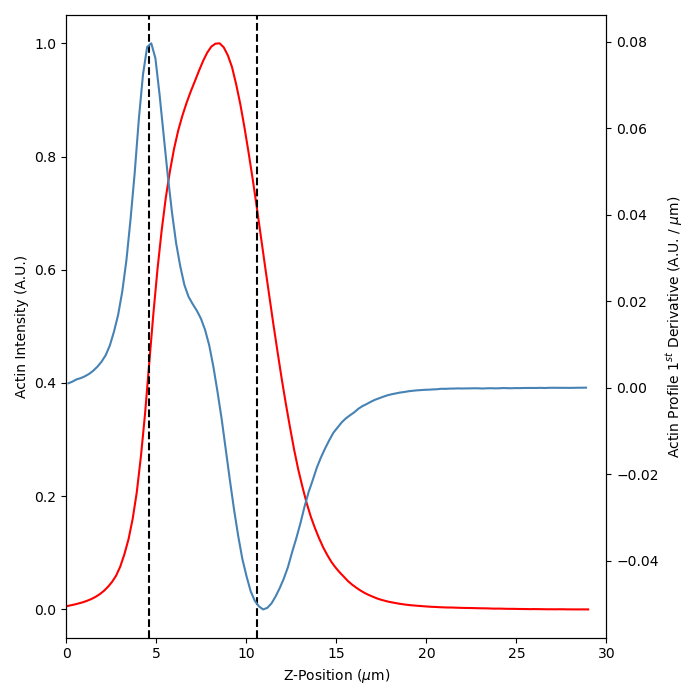

('undef', 1)

In [8]:
find_shoulders(list_of_dfs[i], list_of_unshuffled_images[i], plot = True, actin_channel = 1, invert = False)

### 2E: Terrain Map
A map of the position of the centroids of nuclei projected onto the XY plane of the tissue, displayed as dots. The size of the dots show the relative volumes of nuclei. Dot colors represent relative nuclei positions with respect to the tissue depth.
- Color scale goes from Light orange (most basal) to Purple (most apical).

In [ ]:
terrain_map(list_of_dfs[i], list_of_unshuffled_images[i], plot = True, color = 'magma_r', invert = False)

### 2F: Sub-classify
A map representing the XY field of view of the input 512x512 pixel .tiffs broken into 100x100 pixel sections, color-coded by layer category as determined by the original version of ALAn.

#### Color Key
- lawngreen: Immature
- forestgreen:Intermediate
- steelblue: Mature
- orange: Disorganized

In [ ]:
sub_classify(list_of_dfs[i], list_of_unshuffled_images[i], plot = True, invert = False)

# To-Do List
- Debug fake_layers and Z_projection_with_cutoffs
- Find a space to describe other functions (unless there's no usecases outside of the module)
- Maybe replace some user hard-coded input to having button widgets?
- Clean up commented code in modules
- Clarify documentation & unnamed arguments returned from some functions 
- Look into JupyterLabs